Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
import shutil
shutil.rmtree('Skin cancer ISIC The International Skin Imaging Collaboration', ignore_errors=True)

In [4]:
from zipfile import ZipFile
# Create a ZipFile Object and load sample.zip in it
with ZipFile('/content/drive/MyDrive/Colab Notebooks/CNN Assignment/CNN_assignment.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
# finding the count of train and test images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               subset='training',
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =  tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               subset='validation',
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

Total number of training images:  2239


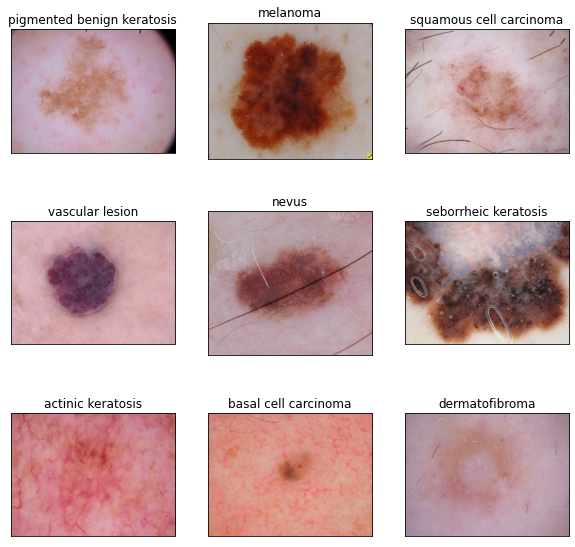

In [11]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
from glob import glob
import glob
train_image_names = glob.glob('Skin cancer ISIC The International Skin Imaging Collaboration/Train/*/*.jpg')
print("Total number of training images: ", len(train_image_names))

# make train_image_names as serie object
train_image_names = pd.Series(train_image_names)

# train_df: a dataframe with 2 field: Filename, ClassId
train_df = pd.DataFrame()

# generate Filename field
train_df['Path'] = train_image_names.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
train_df['Label'] = train_image_names.map(lambda img_name: img_name.split("/")[-2])

plot_df = train_df.drop_duplicates(subset='Label', keep="first").reset_index()
plt.figure(figsize=(10, 10))

for i in range(9):
    label_str = plot_df.loc[i, 'Label']
    img_name = plot_df.loc[i, 'Path']
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(os.path.join('Skin cancer ISIC The International Skin Imaging Collaboration/Train',label_str, img_name)))
    plt.title(label_str)
    plt.xticks([])
    plt.yticks([])

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
num_classes = 9
model = Sequential([
                        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                        layers.Conv2D(16,3, padding='same', activation='relu'),
                        layers.MaxPool2D(),
                        layers.Conv2D(32,3,padding='same', activation='relu'),
                        layers.MaxPool2D(),
                        layers.Conv2D(64,3,padding='same', activation='relu'),
                        layers.MaxPool2D(),
                        layers.Conv2D(128,3,padding='same', activation='relu'),
                        layers.MaxPool2D(),
                        layers.Flatten(),
                        layers.Dense(256, activation='relu'),
                        layers.Dense(num_classes)])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 16s 70ms/step - loss: 1.9733 - accuracy: 0.2489 - val_loss: 1.7943 - val_accuracy: 0.3445
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.8451 - accuracy: 0.3119 - val_loss: 1.7009 - val_accuracy: 0.3982
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.6826 - accuracy: 0.3867 - val_loss: 1.8463 - val_accuracy: 0.3445
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.6069 - accuracy: 0.4152 - val_loss: 1.5169 - val_accuracy: 0.4609
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4141 - accuracy: 0.5073 - val_loss: 1.3864 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3387 - accuracy: 0.5307 - val_loss: 1.5140 - val_accuracy: 0.4743
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2881 - accuracy: 0.5262 - val_loss: 1.3839 - val_accuracy: 0.5235
Epoch 8/20
5

### Visualizing training results

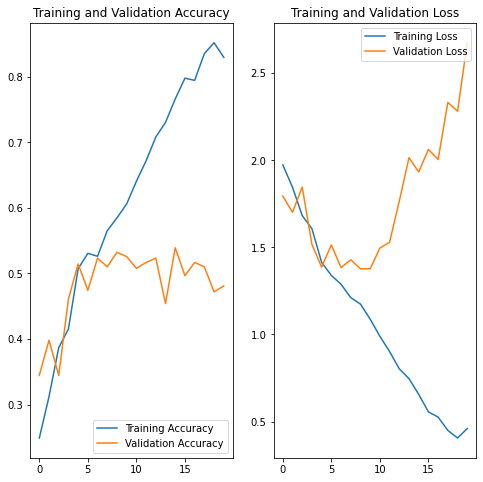

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
<b>from the above test results we can say that model is overfitt</b>

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_aug = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal", input_shape = (img_height, img_width,3)),
     layers.experimental.preprocessing.RandomRotation(0.1),
     layers.experimental.preprocessing.RandomZoom(0.1),
     layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="wrap")
    ]
)


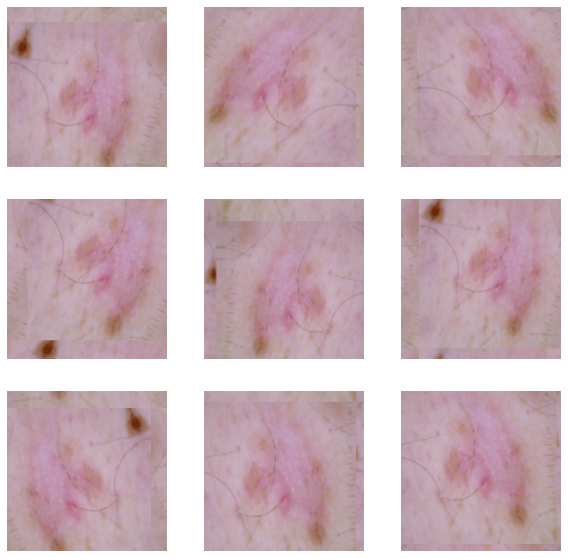

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10,10))

for images, _ in train_ds.take(1):
  for i in range(9):
    aug_images = data_aug(images)
    ax=plt.subplot(3,3,i+1)
    plt.imshow(aug_images[0].numpy().astype('uint8'))
    plt.axis("off");

### Todo:
### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([    data_aug, 
                        layers.experimental.preprocessing.Rescaling(1./255),
                        layers.Conv2D(16,3, padding='same', activation='relu'),
                        layers.MaxPool2D(),
                        layers.Conv2D(32,3,padding='same', activation='relu'),
                        layers.MaxPool2D(),
                        layers.Conv2D(64,3,padding='same', activation='relu'),
                        layers.MaxPool2D(),
                        layers.Conv2D(128,3,padding='same', activation='relu'),
                        layers.MaxPool2D(),
                        layers.Dropout(0.2),
                        layers.Flatten(),
                        layers.Dense(256, activation='relu'),
                        layers.Dense(num_classes)])


### Compiling the model

In [21]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 28ms/step - loss: 1.9788 - accuracy: 0.2617 - val_loss: 1.7338 - val_accuracy: 0.3691
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 1.6750 - accuracy: 0.3560 - val_loss: 1.5938 - val_accuracy: 0.4049
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.6300 - accuracy: 0.3934 - val_loss: 1.5742 - val_accuracy: 0.4385
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5603 - accuracy: 0.4297 - val_loss: 1.7024 - val_accuracy: 0.3893
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5382 - accuracy: 0.4481 - val_loss: 1.7309 - val_accuracy: 0.3937
Epoch 6/20
56/56 [==============================] - 1s 25ms/step - loss: 1.4323 - accuracy: 0.4715 - val_loss: 1.5132 - val_accuracy: 0.4676
Epoch 7/20
56/56 [==============================] - 1s 25ms/step - loss: 1.3842 - accuracy: 0.5017 - val_loss: 1.4372 - val_accuracy: 0.4899
Epoch 8/20
56

### Visualizing the results

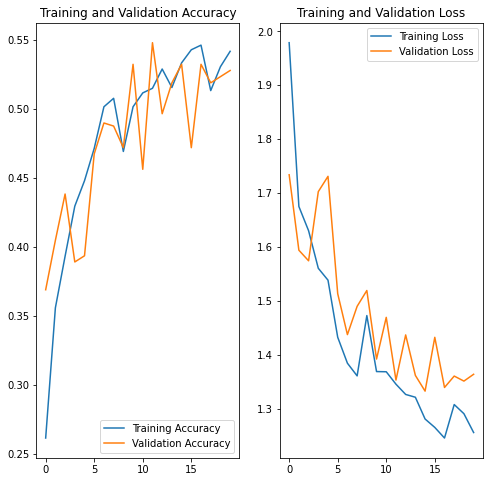

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

<b>Here i can say the model is underfit with not much improvement ,but it reduced some validation accuracy </b>

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

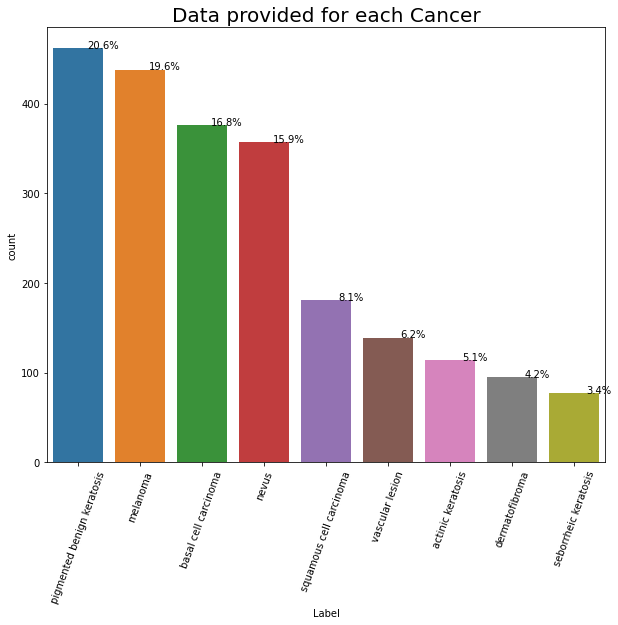

In [24]:
## Your code goes here.
#sns.set(style="whitegrid")
import seaborn as sns
plt.figure(figsize=(10,8))
total = float(len(train_df))
ax = sns.countplot(x="Label", data=train_df,order = train_df['Label'].value_counts().index)
plt.title('Data provided for each Cancer', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.xticks(rotation=70)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
####    <b> Sebarheic keratosis </b>

#### - Which classes dominate the data in terms proportionate number of samples?
####   <b>Pigmented benign keratosis</b>


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
#Checking the values in class_names 
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [27]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD62BF9EDD0>:   0%|          | 1/500 [00:00<01:04,  7.75 Samples/s]                  

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD62BFA53D0>: 100%|██████████| 500/500 [00:16<00:00, 30.49 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD62BF95D90>: 100%|██████████| 500/500 [00:16<00:00, 30.10 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD62BF9E850>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD62BFFBD90>: 100%|██████████| 500/500 [00:17<00:00, 28.61 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1016x682 at 0x7FD6263C0710>:   0%|          | 1/500 [00:00<01:26,  5.75 Samples/s]

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD62BCD9810>: 100%|██████████| 500/500 [01:25<00:00,  5.82 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FD62BCDC3D0>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD6263215D0>: 100%|██████████| 500/500 [01:33<00:00,  5.33 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD62BFB5990>: 100%|██████████| 500/500 [00:16<00:00, 29.82 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FD62B45CB10>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD74A6C3090>: 100%|██████████| 500/500 [00:41<00:00, 12.13 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD6EA41D7D0>:   0%|          | 1/500 [00:00<01:16,  6.50 Samples/s]

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD6EA40E890>: 100%|██████████| 500/500 [00:17<00:00, 29.33 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD62BD0FE50>: 100%|██████████| 500/500 [00:17<00:00, 29.20 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024708.jpg_89895497-a25e-405d-b74d-1eeb856e8ab3.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026422.jpg_29f6bcb0-9675-48c4-9cd1-6120887cc12b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025623.jpg_f14e221c-5640-4a40-a47a-a20966835421.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025388.jpg_07c36d2f-ad5d-4074-a826-ec88eccbdced.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028593.jpg_4367e058-729b-4aef-b716-6f2761eb2d60.jpg',


In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = train_df.append(df2)

In [33]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

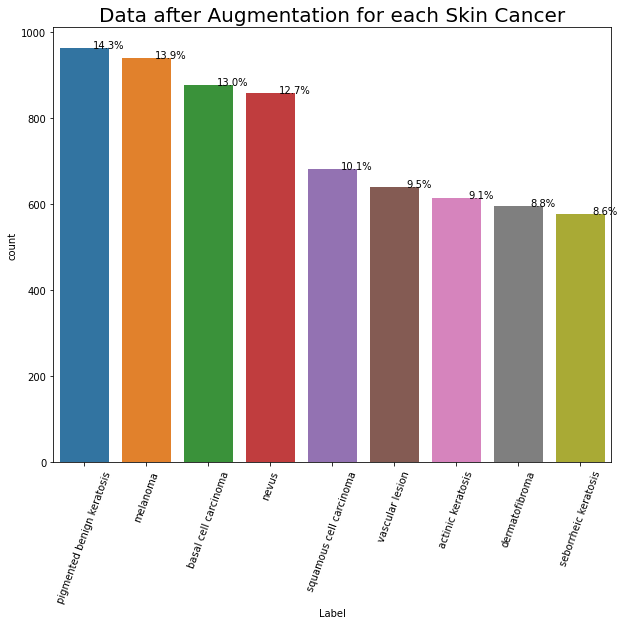

In [34]:
# plotting the distribution of each skin cancer in training dataset
plt.figure(figsize=(10,8))
total = float(len(new_df))
ax = sns.countplot(x="Label", data=new_df,order = new_df['Label'].value_counts().index)
plt.title('Data after Augmentation for each Skin Cancer', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.xticks(rotation=70)
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [36]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [38]:
## your code goes here
model = Sequential([
                        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                        layers.Conv2D(16,3, padding='same', activation='relu'),
                        layers.MaxPool2D(),
                        layers.Conv2D(32,3,padding='same', activation='relu'),
                        layers.MaxPool2D(),
                        layers.Conv2D(64,3,padding='same', activation='relu'),
                        layers.MaxPool2D(),
                        layers.Conv2D(128,3,padding='same', activation='relu'),
                        layers.MaxPool2D(),
                        layers.Dropout(0.25),
                        layers.Flatten(),
                        layers.Dense(256, activation='relu'),
                        layers.Dropout(0.3),
                        layers.Dense(128, activation='relu'),
                        layers.Dense(num_classes)])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [40]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 29s 165ms/step - loss: 1.8649 - accuracy: 0.2749 - val_loss: 1.5961 - val_accuracy: 0.3675
Epoch 2/50
169/169 [==============================] - 27s 154ms/step - loss: 1.5600 - accuracy: 0.3967 - val_loss: 1.4300 - val_accuracy: 0.4350
Epoch 3/50
169/169 [==============================] - 28s 161ms/step - loss: 1.4599 - accuracy: 0.4345 - val_loss: 1.3519 - val_accuracy: 0.4670
Epoch 4/50
169/169 [==============================] - 27s 158ms/step - loss: 1.3916 - accuracy: 0.4522 - val_loss: 1.2277 - val_accuracy: 0.5078
Epoch 5/50
169/169 [==============================] - 28s 159ms/step - loss: 1.2813 - accuracy: 0.5050 - val_loss: 1.2523 - val_accuracy: 0.5026
Epoch 6/50
169/169 [==============================] - 27s 154ms/step - loss: 1.2051 - accuracy: 0.5417 - val_loss: 1.4787 - val_accuracy: 0.4477
Epoch 7/50
169/169 [==============================] - 28s 160ms/step - loss: 1.1382 - accuracy: 0.5644 - val_loss: 1.0561 - val_ac

#### **Todo:**  Visualize the model results

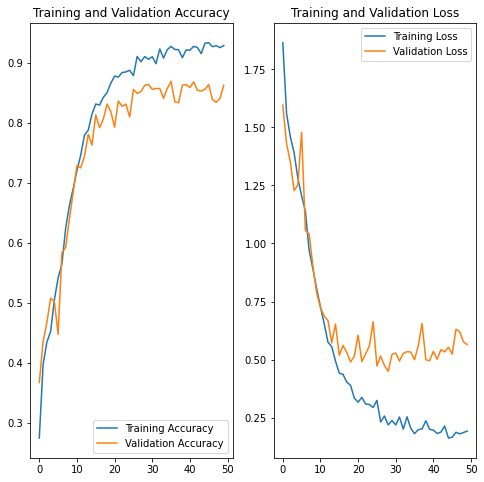

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



i haven't got any underfit or over fit, here i can say model resampling helped to overcome from underfitting